# Training Whisper on huggingface

In my previous article, we learned about the new end-to-end speech recognition model developed by OpenAI: Whisper.

Today, we will go through the steps required to fine-tune a Whisper model using several Huggingface libraries. Furthermore, we will understand in detail how the Huggingface libraries take care of all the different steps under the hood, and how the model learns from the training examples.

But first let me clarify an important point: Whisper models are already trained on downstream tasks, which means that they can be used out-of-the-box to perform several tasks like language-to-language transcription, language-to-english translation, and language identification. But you will achieve better performance on specific distributions (language, domain, specific background noise, ...) if the model is fine-tuned on a a specific dataset.

If you want to learn more about the approach used, training data, model architecture and the extensive evaluation performed by the OpenAI team, [this](https://marinone94.github.io/Whisper-paper/) is the place to start! You will benefit much more from this post afterwards.

Since the scope of the article is to learn about the training process, we will fine-tune the smallest model available - [Whisper Tiny](https://huggingface.co/openai/whisper-tiny) - on the English subset of the [Fleurs](https://huggingface.co/datasets/google/fleurs) dataset. Whisper models have been trained largely on English data, so I don't expect to further improve the performance; still, it will be a good starting point to understand how the training process works, and it will allow everyone to verify the model's predictions. 

## Environment setup

To reproduce the following examples, I recommend you to setup a virtual environment. The code has been tested with the packages listed in the `requirements.txt` file, so I cannot guarantee that different packages or Python versions will run smoothly (although they will mostly will).

In [ ]:
!python3.8 -m venv venv
!source venv/bin/activate
!pip install -r requirements.txt

Let's check that the packages have been installed correctly.

In [2]:
!pip3 freeze

aadv==0.4.3
absl-py==0.11.0
aiohttp==3.8.1
aiosignal==1.2.0
appnope==0.1.2
argon2-cffi==20.1.0
asttokens==2.0.5
async-generator==1.10
async-timeout==4.0.2
attrs==20.3.0
awsmfa==0.2.9
backcall==0.2.0
bertviz==1.4.0
bleach==3.2.1
boto3==1.24.10
botocore==1.27.96
cachetools==4.2.4
captum==0.5.0
certifi==2022.5.18.1
cffi==1.14.4
charset-normalizer==2.0.12
click==7.1.2
cloudpickle==1.6.0
coloredlogs==15.0.1
cycler==0.10.0
datasets==2.2.1
debugpy==1.6.0
decorator==4.4.2
defusedxml==0.6.0
Deprecated==1.2.13
dill==0.3.5.1
docker==4.4.1
docker-pycreds==0.4.0
docstring-parser==0.15
ecco==0.1.2
entrypoints==0.3
et-xmlfile==1.0.1
evaluate==0.1.0
executing==0.8.3
filelock==3.7.1
fire==0.4.0
flatbuffers==22.10.26
frozenlist==1.3.0
fsspec==2022.5.0
gitdb==4.0.9
GitPython==3.1.29
google-api-core==2.10.2
google-api-python-client==1.12.11
google-auth==1.35.0
google-auth-httplib2==0.1.0
google-cloud-core==2.3.2
google-cloud-storage==1.44.0
google-crc32c==1.5.0
google-resumable-media==2.4.0
googleapis-com

## Training dataset

Fleurs is a dataset open-sourced by Google which contains approximately 2000 examples for each language. Each training set has around **10 hours** of supervision, and speakers of the training sets are different from the speakers of the dev and test sets.

This dataset has also been used to evaluate the translation capabilities of Whisper models, since all sentences are translated in all languages and can be matched using their ids.

Before proceeding with the training, let's take a look at the data.

In [3]:
from datasets import load_dataset

dataset = load_dataset("google/fleurs", "en_us", streaming=True)

In [4]:
dataset

{'train': <datasets.iterable_dataset.IterableDataset at 0x7fb1bcae5b80>,
 'validation': <datasets.iterable_dataset.IterableDataset at 0x7fb1bcaf3310>,
 'test': <datasets.iterable_dataset.IterableDataset at 0x7fb1bcaf3ac0>}

As you can see, the dataset contains three splits. Each split is an IterableDataset, since we have loaded it in streaming mode. This means that the dataset is not downloaded, but it is loaded on the fly when needed. This is useful when the dataset occupies too much space on the disk, or if you want to avoid waiting for the whole dataset to be downloaded. Huggingface [docs](https://huggingface.co/docs/datasets/stream) are excellent to learn more about the datasets library and the streaming mode.

But we can still explore the dataset features without downloading it. So let's have a look.

In [5]:
from pprint import pprint

features = dataset['train'].features
pprint(features)

{'audio': Audio(sampling_rate=16000, mono=True, decode=True, id=None),
 'gender': ClassLabel(names=['male', 'female', 'other'], id=None),
 'id': Value(dtype='int32', id=None),
 'lang_group_id': ClassLabel(names=['western_european_we', 'eastern_european_ee', 'central_asia_middle_north_african_cmn', 'sub_saharan_african_ssa', 'south_asian_sa', 'south_east_asian_sea', 'chinese_japanase_korean_cjk'], id=None),
 'lang_id': ClassLabel(names=['af_za', 'am_et', 'ar_eg', 'as_in', 'ast_es', 'az_az', 'be_by', 'bg_bg', 'bn_in', 'bs_ba', 'ca_es', 'ceb_ph', 'ckb_iq', 'cmn_hans_cn', 'cs_cz', 'cy_gb', 'da_dk', 'de_de', 'el_gr', 'en_us', 'es_419', 'et_ee', 'fa_ir', 'ff_sn', 'fi_fi', 'fil_ph', 'fr_fr', 'ga_ie', 'gl_es', 'gu_in', 'ha_ng', 'he_il', 'hi_in', 'hr_hr', 'hu_hu', 'hy_am', 'id_id', 'ig_ng', 'is_is', 'it_it', 'ja_jp', 'jv_id', 'ka_ge', 'kam_ke', 'kea_cv', 'kk_kz', 'km_kh', 'kn_in', 'ko_kr', 'ky_kg', 'lb_lu', 'lg_ug', 'ln_cd', 'lo_la', 'lt_lt', 'luo_ke', 'lv_lv', 'mi_nz', 'mk_mk', 'ml_in', 'mn_mn

Alright, so we can see that the dataset contains a bunch of features we could use for different purposes. To train our speech recognition model, we will use only the `audio` and `raw_transcription` features. But let's look at a sample to understand why we choose only those features. Remember that we loaded the dataset in streaming mode, so we can't access it through indexes since we don't have it in memory yet! By casting it to a list though, the data point will be loaded in memory.

In [6]:
# Get a reference to the first item of the dataset
dataset_head = dataset['train'].take(1)
# Actually download the first item and pprint it
sample = list(dataset_head)[0]
pprint(sample)


{'audio': {'array': array([ 0.        ,  0.        ,  0.        , ...,  0.00068671,
       -0.0013473 , -0.0004167 ]),
           'path': '14223464699748513050.wav',
           'sampling_rate': 16000},
 'gender': 1,
 'id': 823,
 'lang_group_id': 0,
 'lang_id': 19,
 'language': 'English',
 'num_samples': 181440,
 'path': '14223464699748513050.wav',
 'raw_transcription': 'Although most agencies are willing to take on most '
                      'regular bookings, many agents specialise in particular '
                      'types of travel, budget ranges or destinations.',
 'transcription': 'although most agencies are willing to take on most regular '
                  'bookings many agents specialise in particular types of '
                  'travel budget ranges or destinations'}


So, the `audio` feature is a dictionary containing the audio waveform stored as numpy array, the file path and the sampling rate. The `raw_transcription` feature is a string containing the transcription of the audio file. Let's listen to it.

In [8]:
from IPython.display import Audio

print(sample["raw_transcription"])
Audio(sample["audio"]["array"], rate=sample["audio"]["sampling_rate"])

Although most agencies are willing to take on most regular bookings, many agents specialise in particular types of travel, budget ranges or destinations.


As you can hear, the audio is really clear and Whisper should perform well on this example. Let's have a look at the transcription. I will not explain each step here, as you can read all the details in my previous [article](https://marinone94.github.io/Whisper-paper/).

In [9]:
from torch.cuda import is_available as cuda_is_available
from transformers import (
    WhisperProcessor,
    WhisperForConditionalGeneration
)

# If you have a GPU, it will be faster...
device = "cuda" if cuda_is_available() else "cpu"

# Load processor for audio and text
# feature processor (audio) + tokenizer (text)
processor = WhisperProcessor.from_pretrained(
    "openai/whisper-tiny")

# Load model architecture and weights
model = WhisperForConditionalGeneration.from_pretrained(
    "openai/whisper-tiny").to(device)
model_def_max_length = model.config.max_length

# Load audio file (see previous cells)
data = sample["audio"]["array"]
sampling_rate = sample["audio"]["sampling_rate"]
print("Audio loaded. Sample rate: ", sampling_rate)

# Convert input audio to log-mel spectrogram
input_features = processor(
    data, sampling_rate=sampling_rate, return_tensors="pt").input_features.to(device)

# Get tokens to initiate transcription
# and store them in the model config.
# Under the hood, this will force the model to predict
# these tokens in the beginning of the transcription.
init_tokens = processor.get_decoder_prompt_ids(
    language="en", task="transcribe", no_timestamps=True)
model.config.forced_decoder_ids = init_tokens

# Generate transcription tokens
print("Generating transcription...")
transcription_token_ids = model.generate(
    input_features, max_new_tokens=model_def_max_length)
print("Transcription generated.")

# Decode transcription
# NOTE: input_features is a batch of one element,
# and the returned token ids are batched analogously
transcription_token_ids = transcription_token_ids[0]
whisper_transcript = processor.decode(
    transcription_token_ids, skip_special_tokens=True).strip()

# Print result and compare with reference transcript
print("Whisper transcript:\n", whisper_transcript)
reference_transcript = sample["raw_transcription"]
print("Reference transcript:\n", reference_transcript)


Audio loaded. Sample rate:  16000
Generating transcription...
Transcription generated.
Whisper transcript:
 Although most agencies are willing to take on most regular bookings, many agents specialize in particular types of travel, budget ranges or destinations.
Reference transcript:
 Although most agencies are willing to take on most regular bookings, many agents specialise in particular types of travel, budget ranges or destinations.


We can see that the generated and the reference transcripts are identical. As said, this example was quite clean and Whisper was expected to perform well on it, so we shouldn't be surprised. But how do we measure the performance of the model? It is almost time to introduce the standard evaluation metric for speech recognition: the [Word Error Rate](https://en.wikipedia.org/wiki/Word_error_rate). But before that, we should inspect the dataset a bit more. Let's load 100 random samples and look at the distribution of audio duration and transcription length (measured in number of tokens).

As the audio duration is not directly provided, we can infer it from the number of samples and the sampling rate. Let's remove the unnecessary features.

In [10]:
cols_to_keep = ["audio", "raw_transcription", "num_samples"]
cols_to_remove = [col for col in sample.keys() if col not in cols_to_keep]
dataset = dataset.remove_columns(cols_to_remove)

In [11]:
samples = dataset['train'].shuffle().take(100)
samples.features

{'num_samples': Value(dtype='int32', id=None),
 'audio': Audio(sampling_rate=16000, mono=True, decode=True, id=None),
 'raw_transcription': Value(dtype='string', id=None)}

In [12]:
import pandas as pd
from tqdm import tqdm

rows = [row for row in tqdm(samples)]
df = pd.DataFrame(rows, columns=list(samples.features.keys()))

100it [02:32,  1.52s/it]


In [13]:
def audio_length(ns):
    return round(ns / sampling_rate, 2)

def tokenize(text):
    return processor.tokenizer.tokenize(text)

In [14]:
df["audio_length"] = df["num_samples"].apply(audio_length)
df["tokens"] = df["raw_transcription"].apply(tokenize)
df["num_tokens"] = df["tokens"].apply(len)

In [15]:
df.head()

,num_samples,audio,raw_transcription,audio_length,tokens,num_tokens
0,126080,"{'path': None, 'array': [0.0, 0.0, 0.0, 0.0, 0...","Its frequent portrayal in music, films, litera...",7.88,"[I, ts, Ġfrequent, Ġportray, al, Ġin, Ġmusic, ...",32
1,142080,"{'path': None, 'array': [0.0, 0.0, 0.0, 0.0, 0...",Scientists have suspected Enceladus as geologi...,8.88,"[S, cient, ists, Ġhave, Ġsuspected, ĠEn, cel, ...",24
2,177600,"{'path': None, 'array': [0.0, 0.0, 0.0, 0.0, 0...",Mr. Rudd's decision to sign the Kyoto climate ...,11.10,"[Mr, ., ĠRud, d, 's, Ġdecision, Ġ, to, Ġsign, ...",39
3,153600,"{'path': None, 'array': [0.0, 0.0, 0.0, 0.0, 0...",Estimates range from 340 million to 500 millio...,9.60,"[Est, im, ates, Ġrange, Ġfrom, Ġ3, 40, Ġmillio...",27
4,215040,"{'path': None, 'array': [0.0, 0.0, 0.0, 0.0, 0...",Nature-based tourism attracts people intereste...,13.44,"[N, ature, -, based, Ġ, t, our, ism, Ġattracts...",31


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   num_samples        100 non-null    int64  
 1   audio              100 non-null    object 
 2   raw_transcription  100 non-null    object 
 3   audio_length       100 non-null    float64
 4   tokens             100 non-null    object 
 5   num_tokens         100 non-null    int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 4.8+ KB


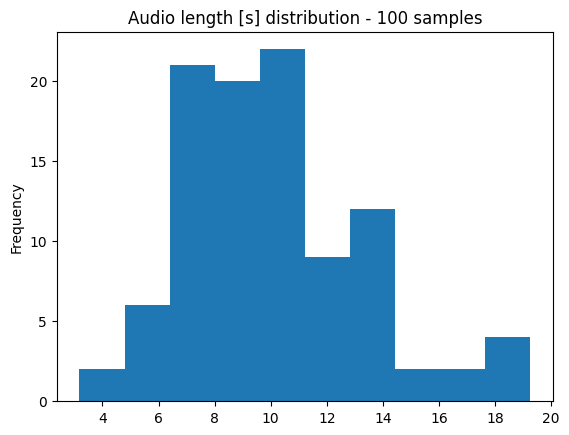

In [17]:
import matplotlib.pyplot as plt

# Plot the histogram
df.audio_length.plot(kind='hist', bins=10)

# Show the plot
plt.title(f"Audio length [s] distribution - {len(df)} samples")
plt.show()

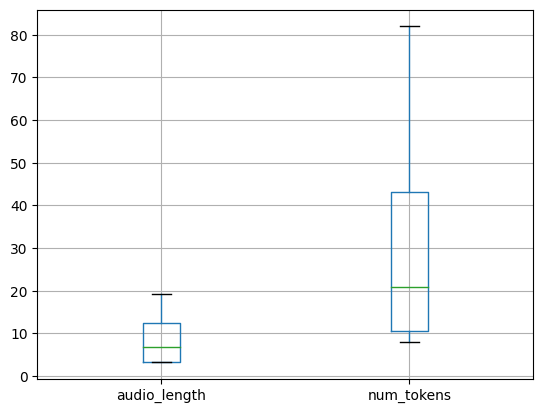

In [18]:
import altair as alt

stats_df = pd.DataFrame({
    "mean": [df.audio_length.mean(), df.num_tokens.mean()],
    "std": [df.audio_length.std(), df.num_tokens.std()],
    "min": [df.audio_length.min(), df.num_tokens.min()],
    "max": [df.audio_length.max(), df.num_tokens.max()],
}, index=["audio_length", "num_tokens"]).T
stats_df
stats_df.boxplot()
plt.show()

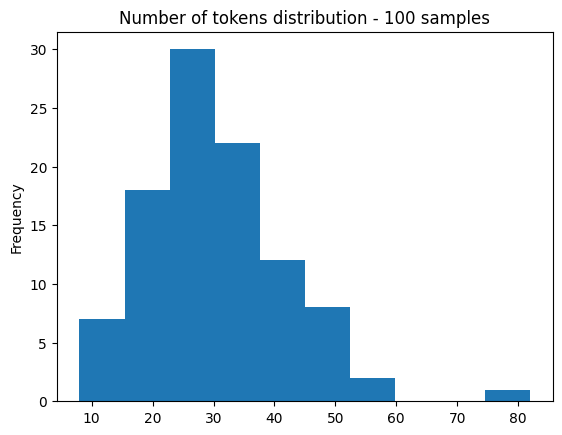

In [19]:
import matplotlib.pyplot as plt

# Plot the histogram
df.num_tokens.plot(kind='hist', bins=10)

# Show the plot
plt.title(f"Number of tokens distribution - {len(df)} samples")
plt.show()

From the plots, we can observe that none of the randomly selected examples is longer than 30 seconds. It is relatively safe to assume then that only a few examples will be truncated during the training. Most of the samples have between 20 and 50 tokens, corresponding to audios between 5 and 15 seconds. Therefore, this dataset might not be the best to fine-tune a model which will then be used to transcribe single words. This is just to remind that we rarely have one dataset which is perfect for all the tasks we want to perform, and it is worth spending some time to understand the dataset before jumping into the training.

Last check: let's have a look the shortest and longest examples (as number of tokens of the reference transcription).

In [20]:
min_num_tokens = stats_df["num_tokens"]["min"]
max_num_tokens = stats_df["num_tokens"]["max"]
print(f"Min number of tokens: {min_num_tokens}")
print(f"Max number of tokens: {max_num_tokens}")

Min number of tokens: 8.0
Max number of tokens: 82.0


In [21]:
short_sample = df[df.num_tokens == min_num_tokens].reset_index().iloc[0]
long_sample = df[df.num_tokens == max_num_tokens].reset_index().iloc[0]

In [22]:
print(short_sample["raw_transcription"])
Audio(short_sample["audio"]["array"], rate=short_sample["audio"]["sampling_rate"])

No one was inside the apartment.


In [23]:
print(long_sample["raw_transcription"])
Audio(long_sample["audio"]["array"], rate=long_sample["audio"]["sampling_rate"])

When a small group of living things (a small population) gets separated from the main population that they came from (like if they move over a mountain range or a river, or if they move to a new island so that they can't easily move back) they will often find themselves in a different environment than they were in before.


In [33]:
import os

from scipy.io.wavfile import write

# This download function is used to embed the files in the blog post.
def save_wav(data, filename, sample_rate, overwrite=False):
    # Create dir if missing
    if not os.path.exists(filename) or overwrite is True:
        os.makedirs(os.path.dirname(filename), exist_ok=True)
        write(filename, sample_rate, data)
        print(f"Saved {filename} with sampling rate {sample_rate}")
    else:
        print(f"File {filename} already exists. Skipping.")


In [35]:
# Save audio files for blog integration
audio_dir = "assets/audio/fleurs_en"
save_wav(short_sample["audio"]["array"], f"{audio_dir}/short_sample.wav", short_sample["audio"]["sampling_rate"])
save_wav(long_sample["audio"]["array"], f"{audio_dir}/long_sample.wav", long_sample["audio"]["sampling_rate"])
 

Saved assets/audio/fleurs_en/short_sample.wav with sampling rate 16000
Saved assets/audio/fleurs_en/long_sample.wav with sampling rate 16000


In [37]:
list(samples.features.keys())

['num_samples', 'audio', 'raw_transcription']

In [ ]:
import evaluate
from transformers import (
    AutoFeatureExtractor,
    AutoModelForSpeechSeq2Seq,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
)

from transformers.models.whisper.english_normalizer import BasicTextNormalizer
from transformers.trainer_pt_utils import IterableDataset, IterableDatasetShard


In [ ]:
output_dir = "./model"
os.makedirs(output_dir, exist_ok=True)
training_args = Seq2SeqTrainingArguments(
    output_dir=output_dir,
    do_train=True,
    do_eval=True,
    evaluation_strategy="steps",
    eval_steps=10,
    logging_strategy="steps",
    logging_steps=10,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
)

In [ ]:


@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    """
    Data collator that will dynamically pad the inputs received.
    Args:
        processor ([`WhisperProcessor`])
            The processor used for processing the data.
        decoder_start_token_id (`int`)
            The begin-of-sentence of the decoder.
    """

    processor: WhisperProcessor
    decoder_start_token_id: int

    def __call__(self, features):
        # split inputs and labels since they have to be of different lengths and need
        # different padding methods
        model_input_name = self.processor.model_input_names[0]
        input_features = [{model_input_name: feature[model_input_name]} for feature in features]
        label_features = [{"input_ids": feature["labels"]} for feature in features]

        batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")

        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        # if bos token is appended in previous tokenization step,
        # cut bos token here as it's append later anyways
        if (labels[:, 0] == self.decoder_start_token_id).all().cpu().item():
            labels = labels[:, 1:]

        batch["labels"] = labels

        return batch

feature_extractor = AutoFeatureExtractor.from_pretrained("openai/whisper-tiny")        
model = AutoModelForSpeechSeq2Seq.from_pretrained("openai/whisper-tiny")
    
# We only need to set the task id when the language is specified (i.e. in a multilingual setting)
feature_extractor.tokenizer.set_prefix_tokens(language="en", task="transcribe")

normalizer = BasicTextNormalizer()  # 'official' text normalizer from OpenAI

# Sample dataset for demo
dataset["train"] = dataset["train"].shuffle(seed=42).take(8)
dataset["validation"] = dataset["validation"].shuffle(seed=42).take(4)
dataset["test"] = dataset["test"].shuffle(seed=42).take(4)

def prepare_dataset(batch, normalize=False):
    # process audio
    sample = batch["audio"]
    inputs = feature_extractor(sample["array"], sampling_rate=sample["sampling_rate"])
    # process audio length
    # batch[model_input_name] = inputs.get(model_input_name)[0]
    batch["input_length"] = len(sample["array"])

    # process targets
    if normalize is True:
        labels = batch["raw_transcription"].lower()
        labels = normalizer(labels).strip()
    else:
        labels = batch["raw_transcription"].strip()
    batch["labels"] = feature_extractor.tokenizer(labels).input_ids
    return batch

# In real training, you will want to remove useless columns, but now we preserve them to inspec data
# raw_datasets_features = list(next(iter(raw_datasets.values())).features.keys())
dataset["train"] = dataset["train"].map(
    prepare_dataset,
    batched=True,
    fn_kwargs={"normalize": False},
    # remove_columns=list(dataset.features.keys()),
).with_format("torch")
dataset["validation"] = dataset["validation"].map(
    prepare_dataset,
    batched=True,
    fn_kwargs={"normalize": True},
    # remove_columns=list(dataset.features.keys()),
).with_format("torch")
dataset["test"] = dataset["test"].map(
    prepare_dataset,
    batched=True,
    fn_kwargs={"normalize": True},
    # remove_columns=list(dataset.features.keys()),
).with_format("torch")

# 8. Load Metric
metric = evaluate.load("wer")


def calc_wer(pred):
    pred_ids = pred.predictions

    pred.label_ids[pred.label_ids == -100] = feature_extractor.tokenizer.pad_token_id

    pred_str = feature_extractor.tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    # we do not want to group tokens when computing the metrics
    label_str = feature_extractor.tokenizer.batch_decode(pred.label_ids, skip_special_tokens=True)

    
    pred_str = [normalizer(pred) for pred in pred_str]
    label_str = [normalizer(label) for label in label_str]
    # filtering step to only evaluate the samples that correspond to non-zero references:
    pred_str = [pred_str[i] for i in range(len(pred_str)) if len(label_str[i]) > 0]
    label_str = [label_str[i] for i in range(len(label_str)) if len(label_str[i]) > 0]

    wer = 100 * metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer}


# save feature extractor, tokenizer and config
feature_extractor.save_pretrained(output_dir)

# 10. Define data collator
data_collator = DataCollatorSpeechSeq2SeqWithPadding(
    processor=feature_extractor.processor,
    decoder_start_token_id=model.config.decoder_start_token_id,
)

# 11. Configure Trainer
# Trainer callback to reinitialise and reshuffle the streamable datasets at the beginning of each epoch
# Only required for streaming: Trainer automatically shuffles non-streaming datasets
class ShuffleCallback(TrainerCallback):
    def on_epoch_begin(self, args, state, control, train_dataloader, **kwargs):
        if isinstance(train_dataloader.dataset, IterableDatasetShard):
            pass  # set_epoch() is handled by the Trainer
        elif isinstance(train_dataloader.dataset, IterableDataset):
            train_dataloader.dataset.set_epoch(train_dataloader.dataset._epoch + 1)

# Initialize Trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["eval"],
    tokenizer=feature_extractor.tokenizer,
    data_collator=data_collator,
    compute_metrics=calc_wer,
    callbacks=[ShuffleCallback()]
)

# 12. Training
train_result = trainer.train()
trainer.save_model()  # Saves the feature extractor too for easy upload

metrics = train_result.metrics
trainer.log_metrics("train", metrics)
trainer.save_metrics("train", metrics)
trainer.save_state()
print(metrics)

# 13. Evaluation
metrics = trainer.evaluate(
    eval_dataset=dataset["test"],
    metric_key_prefix="test",
    max_length=448,
    num_beams=1,
)

trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)
print(metrics)

In [ ]:
# Load train model and do prediction